In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import polars as pl
from datetime import timedelta
import datetime 
import json 
import toml
import holidays
import sys

features = toml.load(r'C:\Users\N000193384\Documents\sncf_project\sncf_playground\attendance\data\features.toml')
times_cols = features['times_cols']
macro_horizon = features['MACRO_HORIZON']
p = Path(features['ABS_DATA_PATH'])
sys.path.insert(1, p)

from src.preprocessing.times import (
    from_day_to_time_fe,
    get_covid_table,
)
from src.preprocessing.quality import trim_timeseries, minimum_length_uid
from src.models.forecast.direct import DirectForecaster
from src.preprocessing.lags import get_significant_lags
from src.preprocessing.times import get_basic_holidays
from src.project_utils import load_data
from src.models.lgb_wrapper import GBTModel
from src.preprocessing.validation import freeze_validation_set
from src.preprocessing.lags import compute_autoreg_features

ts_uid = features["ts_uid"]
date_col = features['date_col']
y = features['y']
submit = False 
flist = features["flist"]
long_horizon = np.arange(macro_horizon)
chains = np.array_split(long_horizon, 6)
exog = ["job", "ferie", "vacances"] + times_cols

with open('data/params.json', 'rb') as stream:
    params_q = json.load(stream)

in_dt = datetime.date(2020, 6, 1)

covid_df = get_covid_table(2015, 2024)
df_dates = df_dates = get_basic_holidays()
holidays_fe = list(filter(lambda x: date_col not in x, df_dates.columns))
covid_fe = list(filter(lambda x: date_col not in x, covid_df.columns))
exog = exog + holidays_fe + covid_fe

# evaluate

In [15]:
submission

index
str
"""2023-01-01_1J7"""
"""2023-01-01_O2O"""
"""2023-01-01_8QR"""
"""2023-01-01_L58"""
"""2023-01-01_UMC"""
…
"""2023-05-31_N9K"""
"""2023-05-31_P6E"""
"""2023-05-31_BDC"""


In [13]:
base_col = [ts_uid, date_col, y, "day_of_year"]

from src.preprocessing.lags import reference_shift_from_day
from src.analysis.metrics import display_metrics

train_data, test_data, submission = load_data(p)


def freeze_validation_set(
    df: pl.DataFrame,
    date: str,
    val_size: int,
    return_train: bool = True,
) -> pl.DataFrame:
    max_dt = df[date].max()
    cut = max_dt - timedelta(days=val_size)
    valid = df.filter(pl.col(date) > cut)  # .select([ts_uid, date, target])
    if return_train:
        train = df.filter(pl.col(date) <= cut)
        return train, valid
    else:
        return valid
    

baseline = (train_data
    .pipe(from_day_to_time_fe, time="date", frequency="day")
    .pipe(reference_shift_from_day,    
        target_col=y, 
        ts_uid=ts_uid,
        dayofyear_col="day_of_year"       )
    .pipe(freeze_validation_set, return_train=False, date=date_col, val_size=181)
    .with_columns(
        pl.coalesce(
            pl.col('reference_y'), 
            pl.col('reference_y').mean().over(ts_uid),
            pl.col('reference_y').mean(),
            0
            )
    )
    .select(["index", date_col, ts_uid, y, "reference_y"])
)

del test_data
import gc
gc.collect()
import os 

In [14]:
all_files = list(filter(lambda s : ".csv" in s, os.listdir('out/')))
fcol = []
for files in all_files:
    print(files)
    if files not in ['global_direct_mlp.csv', 'nixtla_validation.csv', "gam.csv", "global_rolling_zscore_direct_mlp.csv",
                     'prophet.csv', 'neural_validation.csv', 'mlp_forecast.csv']:
        fcst_col = files.replace('lgb', 'y_hat').replace('.csv', '')
        init = baseline.shape[0]
        baseline = baseline.join(
            (pl.read_csv(f'out/{files}', 
                        separator=",", 
                        infer_schema_length=1000,
                        columns=[ts_uid, date_col, files.replace('lgb', 'y_hat').replace('.csv', '')]
            ).with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
            .unique(subset=[ts_uid, date_col])
            ), 
            how="left", on=[ts_uid, date_col]
        )
        if baseline.shape[0] != init:
            print(files, baseline.shape, "warning shape")
        fcol.append(fcst_col)


statsmodel_valid = (pl.read_csv('out/nixtla_validation.csv', separator=",", infer_schema_length=1000)
                    .rename({"unique_id":ts_uid, "ds":date_col})
                    .select([ts_uid, date_col, 'HoltWinters', 'AutoETS', "AutoARIMA",
                              'AutoTheta', 'AutoTBATS', 'arithmetic_forecast_ensamble']
                              ).with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
)

gam_model =  (pl.read_csv('out/gam.csv',  separator=",", infer_schema_length=1000)
              .rename({"y_hat":"gam_pred"})
              .with_columns(pl.col(date_col).str.to_datetime().cast(pl.Date)
              ))

nfcst  = ["TimesNet"	,"NHITS"	,"NBEATSx"	, "PatchTST"	,"TSMixerx"	, "iTransformer", "ensamble_forecast"]
neural_fcst_model = pl.read_csv("out/neural_validation.csv", separator=",", infer_schema_length=1000) 
for col in nfcst:
    neural_fcst_model = neural_fcst_model.with_columns(pl.lit(np.expm1(neural_fcst_model[col])).alias(col))
neural_fcst_model = neural_fcst_model.rename({"unique_id":ts_uid, "ds":date_col, "ensamble_forecast":"deep_ensemble"})
neural_fcst_model = neural_fcst_model.with_columns(pl.col(date_col).cast(pl.Date))
nfcst = nfcst[:-1] # + ["deep_ensemble"]


prophet_m = (pl.read_csv('out/prophet.csv', infer_schema_length=1000)
                     .with_columns(pl.col("ds").str.to_datetime().cast(pl.Date).alias(date_col))
                     .rename({"unique_id":ts_uid, "yhat":"prophet_yhat"})
)

prophet_m = prophet_m.with_columns(pl.lit(np.expm1(prophet_m['prophet_yhat'])))


mlp_global_valid  = (pl.read_csv('out/global_direct_mlp.csv', separator=",", infer_schema_length=1000)
                     .with_columns(pl.col(date_col).cast(pl.Date).alias(date_col))
                     .rename({"global_direct_y_hat":"global_direct_mlp_y_hat"})
)
mlp_global_valid = mlp_global_valid.with_columns(pl.lit(np.expm1(mlp_global_valid['global_direct_mlp_y_hat'])))


baseline = (baseline
    .join(statsmodel_valid, how="left",  on=[ts_uid, date_col]    )
    .join(mlp_global_valid.select([ts_uid, date_col, 'global_direct_mlp_y_hat']), how="left", on = [ts_uid, date_col])
    .join(neural_fcst_model, how="left", on = [ts_uid, date_col])
    .join(prophet_m, how="left", on = [ts_uid, date_col])
    .join(gam_model, how="left", on=[ts_uid, date_col])
)

fcol = fcol + nfcst + ['reference_y', 'prophet_yhat', 'global_direct_mlp_y_hat', "gam_pred"]


gam.csv
global_direct_mlp.csv
global_log_chain_lgb.csv
global_log_direct_lgb.csv
global_mean_chain_lgb.csv
global_mean_direct_lgb.csv
global_median_chain_lgb.csv
global_median_direct_lgb.csv
global_None_chain_lgb.csv
global_None_direct_lgb.csv
global_rolling_mean_chain_lgb.csv
global_rolling_mean_direct_lgb.csv
global_rolling_median_chain_lgb.csv
global_rolling_median_direct_lgb.csv
global_rolling_zscore_chain_lgb.csv
global_rolling_zscore_direct_lgb.csv
global_rolling_zscore_direct_mlp.csv
global_shiftn_chain_lgb.csv
global_shiftn_direct_lgb.csv
local_log_direct_lgb.csv
local_mean_direct_lgb.csv
local_median_direct_lgb.csv
local_None_chain_lgb.csv
local_None_direct_lgb.csv
local_rolling_mean_chain_lgb.csv
local_rolling_mean_direct_lgb.csv
local_rolling_median_chain_lgb.csv
local_rolling_median_direct_lgb.csv
local_rolling_zscore_chain_lgb.csv
local_rolling_zscore_direct_lgb.csv
local_shiftn_chain_lgb.csv
local_shiftn_direct_lgb.csv
mlp_forecast.csv
neural_validation.csv
nixtla_validat

In [8]:
metrics_output_df = []
for col in fcol:
    metrics_output_df.append(
        display_metrics(
        baseline[y].to_numpy(), 
        np.clip(baseline[col].fill_null(0).to_numpy(), a_min=0, a_max=None),
        name=col
        ).transpose()
    )

allmet = pd.concat(metrics_output_df, axis=1)
allmet.columns = allmet.iloc[0, :]
display(allmet.T.style.highlight_min(color="blue"))

,fname,rmse,bias,forecast_congruence,wfiab,mae,smape,mape
fname,,,,,,,,
global_log_chain_y_hat,global_log_chain_y_hat,3962.977871,967.089964,3843.191346,0.728455,1173.050474,33.166565,1.589305
global_log_direct_y_hat,global_log_direct_y_hat,3667.813896,939.968886,3545.345992,0.733818,1150.509541,34.048720,1.633128
global_mean_chain_y_hat,global_mean_chain_y_hat,2145.634966,122.286310,2142.161110,0.845017,695.532441,37.244053,2.170812
global_mean_direct_y_hat,global_mean_direct_y_hat,2209.008900,144.718646,2204.277443,0.836942,730.384143,40.096291,2.213627
global_median_chain_y_hat,global_median_chain_y_hat,2081.285685,141.602165,2076.476375,0.846037,690.733618,38.970486,2.153098
global_median_direct_y_hat,global_median_direct_y_hat,2185.431198,199.704933,2176.301474,0.839368,718.317130,37.845596,2.157591
global_None_chain_y_hat,global_None_chain_y_hat,2144.945399,110.258381,2142.123388,0.843621,701.977758,32.424913,2.201060
global_None_direct_y_hat,global_None_direct_y_hat,2190.189949,145.268936,2185.380996,0.841488,712.375972,32.190423,2.284492
global_rolling_mean_chain_y_hat,global_rolling_mean_chain_y_hat,2212.490639,6.730149,2212.494567,0.848791,681.675168,32.974041,2.122876


In [12]:
rmsse_df = allmet.loc['rmse'] 
rmsse_df /= rmsse_df['reference_y']
rmsse_df = rmsse_df.to_frame('rmsse').reset_index()
rmsse_df

,fname,rmsse
0,global_log_chain_y_hat,0.995024
1,global_log_direct_y_hat,0.920915
2,global_mean_chain_y_hat,0.538726
3,global_mean_direct_y_hat,0.554638
4,global_median_chain_y_hat,0.522569
5,global_median_direct_y_hat,0.548718
6,global_None_chain_y_hat,0.538553
7,global_None_direct_y_hat,0.549913
8,global_rolling_mean_chain_y_hat,0.555512
9,global_rolling_mean_direct_y_hat,0.630062


C:\Users\N000193384\AppData\Local\Temp\ipykernel_35236\1648481898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsse_df['fname'] = np.where(rmsse_df['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", rmsse_df['fname'])
C:\Users\N000193384\AppData\Local\Temp\ipykernel_35236\1648481898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", rmsse_df['fname'])
C:\Users\N000193384\AppData\Loc

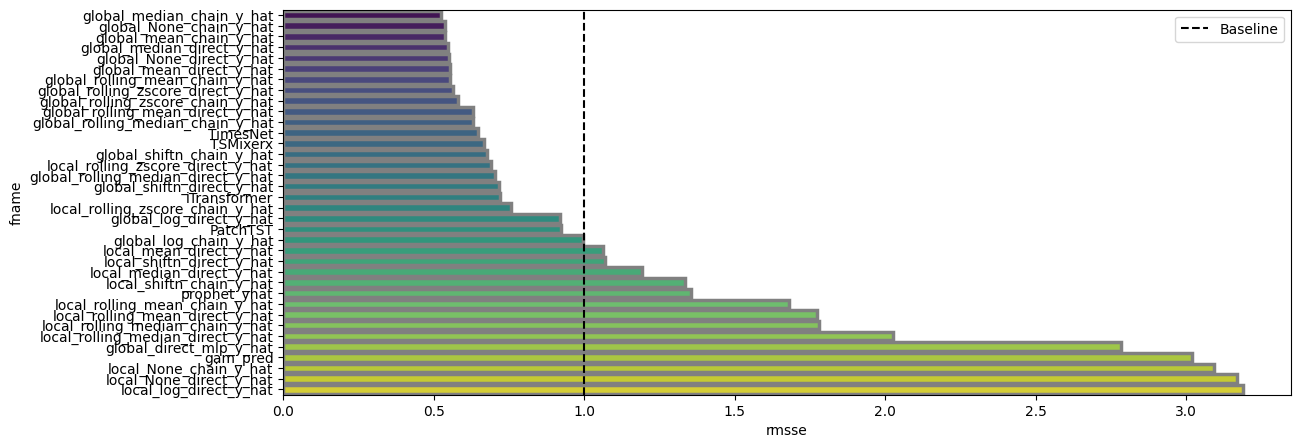

In [10]:
import seaborn as sns 
import matplotlib.pyplot as plt

rmsse_df = rmsse_df.loc[~rmsse_df["fname"].isin(['reference_y', 'all_ensemble', 'ensemble', 'lgb_ensemble', "local_direct_y_hat", "NBEATSx", "NHITS"])]
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", rmsse_df['fname'])
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", rmsse_df['fname'])
rmsse_df['fname'] = np.where(rmsse_df['fname'] == "global_chain_y_hat", "LightGBM Chained Forecast", rmsse_df['fname'])

plt.figure(figsize=(13, 5))
sns.barplot(rmsse_df.sort_values(by="rmsse"), x="rmsse", y="fname",
            errorbar=("pi", 50), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    linewidth=2.5, edgecolor=".5",
    palette="viridis",
)

plt.axvline(1.0, label="Baseline", color="black", linestyle='--')
plt.legend()

In [11]:
plt.figure(figsize=(13, 5))
sns.barplot(rmsse_df.loc[rmsse_df.index.isin(list(filter(lambda x : "global" in x, rmsse_df.index)))].sort_values(by="rmsse"), x="rmsse", y="fname",
            errorbar=("pi", 50), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    linewidth=2.5, edgecolor=".5",
    palette="viridis",
)

plt.axvline(1.0, label="Baseline", color="black", linestyle='--')
plt.legend()

TypeError: argument of type 'int' is not iterable

<Figure size 1300x500 with 0 Axes>

In [ ]:
dt = baseline['date'].unique()
split_dt = np.array_split(dt, 5)
bycut = []
for sdt in split_dt:
    metrics_output_df = []
    b_cut = baseline.filter(pl.col("date").is_in(sdt))
    for col in forecast_cols:
        metrics_output_df.append(
            display_metrics(
            baseline[y].to_numpy(), 
            np.clip(baseline[col].fill_null(0).to_numpy(), a_min=0, a_max=None),
            name=col
            ).transpose()
        )

    allmet = pd.concat(metrics_output_df, axis=1)
    allmet.columns = allmet.iloc[0, :]
    rmsse_df = allmet.loc['rmse'] 
    rmsse_df /= rmsse_df['reference_y']
    rmsse_df = rmsse_df.to_frame('rmsse')
    rmsse_df['date_range'] = str(b_cut['date'].min()) + ' - ' + str(b_cut['date'].max())
    # display(allmet)
    bycut.append(rmsse_df)

import seaborn as sns 
import matplotlib.pyplot as plt

data_ = pd.concat(bycut).reset_index()
data_ = data_.loc[~data_["fname"].isin(['reference_y', 'all_ensemble', 'ensemble', 'lgb_ensemble', "local_direct_y_hat", "NBEATSx", "NHITS"])]
data_['fname'] = np.where(data_['fname'] == "arithmetic_forecast_ensamble", "statistical_ensemble", data_['fname'])
data_['fname'] = np.where(data_['fname'] == "global_direct_y_hat", "LightGBM Direct Forecast", data_['fname'])
data_['fname'] = np.where(data_['fname'] == "global_chain_y_hat", "LightGBM Chained Forecast", data_['fname'])

plt.figure(figsize=(13, 5))
sns.barplot(data_.sort_values(by="rmsse"), x="date_range", y="rmsse", hue="fname",     errorbar=("pi", 50), capsize=.4,
    err_kws={"color": ".5", "linewidth": 2.5},
    linewidth=2.5, edgecolor=".5",
    palette="viridis",
)

plt.axhline(1.0, label="Baseline", color="black", linestyle='--')
plt.legend()

NameError: name 'baseline' is not defined

In [ ]:
import matplotlib.pyplot as plt 

uids = baseline['station'].unique()
n = 6
choice = np.random.choice(uids, (n, ))

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(3, 2, figsize=(20, 16))
axs = axs.ravel()  # Aplatir le tableau 2D des axes pour itération facile

# Tracer les graphiques
for i, uid in enumerate(uids, start=0):
    if i  < n :
        subset_tr = train_data.filter(
            pl.col(ts_uid) == uid, 
            pl.col('date') >= pl.datetime(2021, 1, 1), 
            pl.col('date') < subset['date'].min()
            ).sort(by='date')
        subset = baseline.filter(pl.col(ts_uid) == uid).sort(by='date')
        axs[i].plot(subset_tr["date"], subset_tr['y_copy'], label="train", color="brown", alpha=0.8)
        axs[i].scatter(subset["date"], subset['y'], label="real", color="blue", alpha=1, marker="*")
        for col in list(filter(lambda x : 'y_hat' in x ,forecast_cols)):
            axs[i].scatter(subset["date"], subset[col], label=col, alpha=0.5, marker="x")
        axs[i].axvline(subset['date'].min())
        axs[i].set_title(f'Graph for ID {uid}')
        axs[i].legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

overall_valid =  baseline.group_by('date').agg([pl.col(col).sum() for col in forecast_cols])
overall_hist =  train_data.filter(
            pl.col('date') >= pl.datetime(2021, 1, 1), 
            pl.col('date') < subset['date'].min()
            ).sort(by='date').group_by('date').agg(pl.col(y).sum())

overall_realise =  train_data.filter(
            pl.col('date') >= subset['date'].min()
            ).sort(by='date').group_by('date').agg(pl.col(y).sum())

plt.figure(figsize=(25, 6))
plt.scatter(
    overall_hist['date'], overall_hist['y'], label="train", marker="o"
)
plt.scatter(
    overall_realise['date'], overall_realise['y'], label="realise", marker="o"
)
for col in forecast_cols:
    plt.scatter(
        overall_valid['date'], overall_valid[col], label=f"{col}_valid", marker="*"
    )
plt.legend()

NameError: name 'baseline' is not defined